# Mount and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My Drive/Cardiac Project/Network_phase/mutgan

/content/drive/.shortcut-targets-by-id/1T4XU2DwFBpucge5DbMQ0wVZaRLkXQ564/Cardiac Project/Network_phase/mutgan


In [3]:
!pip install neurite

     |████████████████████████████████| 86 kB 3.1 MB/s 


In [4]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle
import neurite as ne
import random

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from torch.backends import cudnn

from models import lstm_conv3d, lstm
from utils import losses

# Data

## load

In [5]:
with open('./data/train_dataset_augmented.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

with open('./data/val_dataset.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

with open('./data/test_dataset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

## visualize

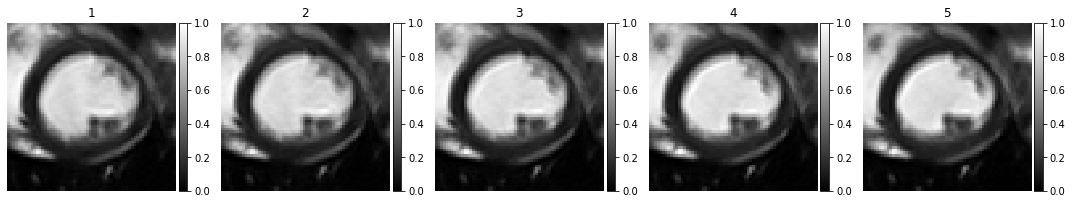

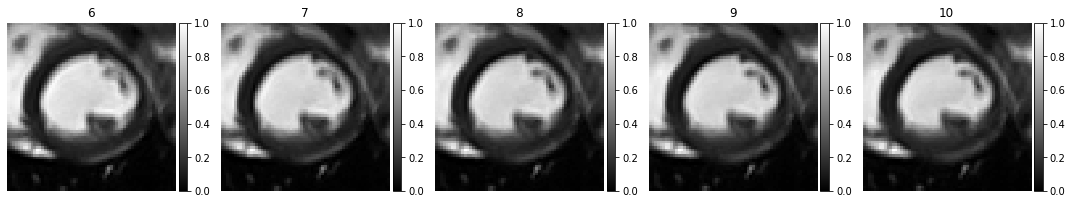

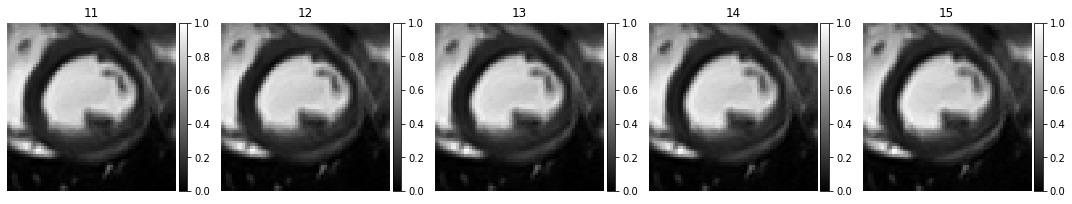

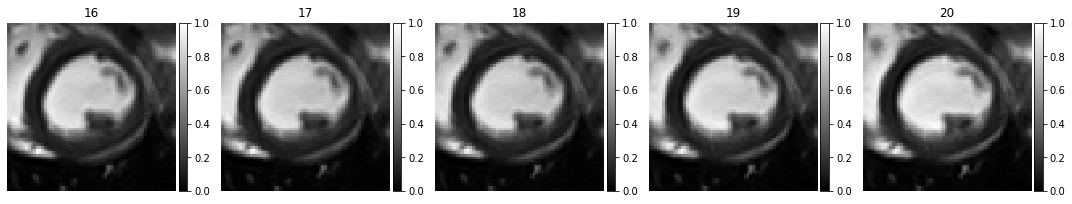

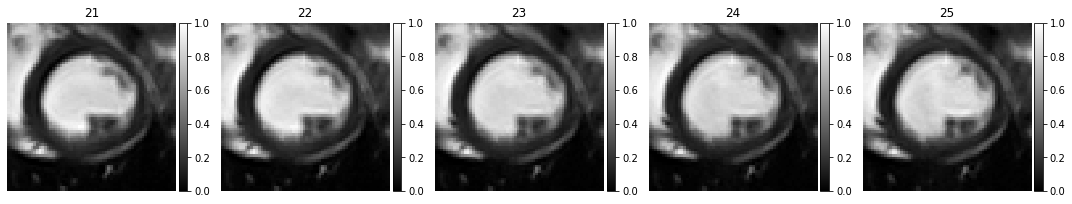

In [6]:
patient = train_dataset[0]
cine_seri, mask = patient['image'], patient['label']
cine_seri = cine_seri.squeeze(0).permute(2, 0, 1)
mask = mask.squeeze(0)

# visualize
frames = [cine_seri[i].cpu().numpy() for i in range(cine_seri.shape[0])]
for i in [0, 5, 10, 15, 20]:
    ne.plot.slices(frames[i:i+5], cmaps=['gray'], do_colorbars=True, titles=list(range(i+1, i+1+5)), imshow_args=[{'origin':'lower'}]);

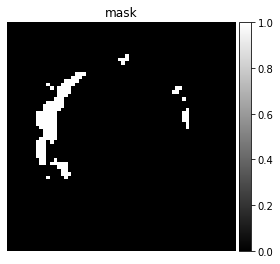

In [7]:
ne.plot.slices([mask.numpy()], cmaps=['gray'], do_colorbars=True, titles=['mask'], imshow_args=[{'origin':'lower'}], width=4);

## dataloader

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class Dataset_(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        patient = self.data[index]
        cine_seri = patient['image'].squeeze(0).permute(2, 0, 1)
        mask = patient['label'].squeeze(0)

        return cine_seri.float(), mask.float()


def get_dataloader(data, batch_size, shuffle=True, pin_memory=False, workers=0):
    dataset = Dataset_(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory,num_workers=workers)
    
    return dataloader

# Set Seed

In [9]:
cudnn.benchmark = False
cudnn.deterministic = True
torch.cuda.manual_seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)

# Args

In [10]:
class Args():
    def __init__(self):        
        self.lr = 0.001
        self.epochs = 50
        self.batch_size = 64
        self.seq_len = 25 
        self.height = 64
        self.width = 64
        self.stages_num = 1

        # choices: ['dice', 'ncc', 'mse', 'accuracy']
        self.loss = 'dice' 
        
args = Args()

# Run

## dataloader

In [11]:
train_dataloader = get_dataloader(train_dataset, args.batch_size)
valid_dataloader = get_dataloader(val_dataset, args.batch_size)
test_dataloader = get_dataloader(test_dataset, args.batch_size)

In [12]:
print('train size:', len(train_dataloader.dataset))
print('valid size:', len(valid_dataloader.dataset))
print('test size:', len(test_dataloader.dataset))

train size: 432
valid size: 37
test size: 21


## model

In [13]:
model = lstm_conv3d.LSTM_Conv3D(args.seq_len, args.height, args.width, args.stages_num)
model.to('cuda')

LSTM_Conv3D(
  (blocks): ModuleList(
    (0): LSTM(4096, 4096, batch_first=True)
    (1): Conv3d(1, 1, kernel_size=(25, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  )
  (sigmoid): Sigmoid()
)

In [14]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', total_params)

number of params: 134250722


## optimizer & scheduler

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=1e-8, verbose=True)

## loss

In [16]:
if args.loss == 'dice':
    loss_function = losses.Dice().loss
elif args.loss == 'ncc':
    loss_function = losses.NCC().loss
elif args.loss == 'mse':
    loss_function = losses.MSE().loss
elif args.loss == 'accuracy':
    loss_function = losses.Accuracy().loss
else:
    raise Exception('Invalid loss function.')

## train

In [17]:
train_loss_history = []
val_loss_history = []

for epoch in range(args.epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0
    start_time = time.time()

    model.train()
    for cine_seri, target_mask in train_dataloader:
        # cine_seri.shape: (bs, seq_len, H, W), target_mask.shape: (bs, H, W)
        bs = target_mask.shape[0]
        pred_mask = model(cine_seri.to('cuda'))
        loss = loss_function(target_mask.to('cuda'), pred_mask)

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss * bs

        # # perform gradient clipping to prevent gradients from exploding
        # _ = torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
    train_epoch_time = time.time() - start_time
    train_epoch_loss /= len(train_dataloader.dataset)
    train_loss_history.append(train_epoch_loss)

    model.eval()
    for cine_seri, target_mask in valid_dataloader:
        bs = target_mask.shape[0]
        with torch.no_grad():
            pred_mask = model(cine_seri.to('cuda'))
            loss = loss_function(target_mask.to('cuda'), pred_mask)
        val_epoch_loss += loss * bs    
    val_epoch_time = (time.time() - start_time) - train_epoch_time
    val_epoch_loss /= len(valid_dataloader.dataset)
    val_loss_history.append(val_epoch_loss)

    scheduler.step(val_epoch_loss)
    
    print('epoch %d:  train_loss=%.5f, val_loss=%.5f, train_time=%.2f, val_time=%.2f'
          % (epoch, train_epoch_loss, val_epoch_loss, train_epoch_time, val_epoch_time))

epoch 0:  train_loss=-0.09439, val_loss=-0.11397, train_time=6.56, val_time=0.94
epoch 1:  train_loss=-0.14108, val_loss=-0.13599, train_time=6.40, val_time=0.95
epoch 2:  train_loss=-0.15820, val_loss=-0.14333, train_time=6.30, val_time=0.96
epoch 3:  train_loss=-0.16407, val_loss=-0.14633, train_time=6.35, val_time=0.95
epoch 4:  train_loss=-0.16667, val_loss=-0.14778, train_time=6.31, val_time=0.94
epoch 5:  train_loss=-0.16825, val_loss=-0.14875, train_time=6.29, val_time=0.94
epoch 6:  train_loss=-0.16922, val_loss=-0.14930, train_time=6.31, val_time=0.95
epoch 7:  train_loss=-0.16998, val_loss=-0.14992, train_time=6.31, val_time=0.93
epoch 8:  train_loss=-0.17065, val_loss=-0.15026, train_time=6.33, val_time=0.95
epoch 9:  train_loss=-0.17131, val_loss=-0.15058, train_time=6.28, val_time=0.94
epoch 10:  train_loss=-0.17184, val_loss=-0.15097, train_time=6.26, val_time=0.93
epoch 11:  train_loss=-0.17238, val_loss=-0.15139, train_time=6.29, val_time=0.93
epoch 12:  train_loss=-0.1

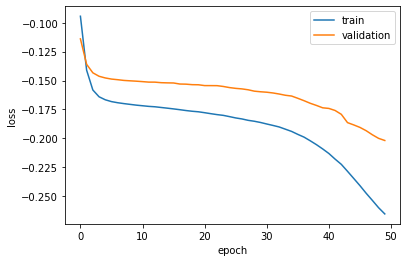

In [18]:
fig = plt.figure()
plt.plot(range(len(train_loss_history)), train_loss_history,  label='train')
plt.plot(range(len(val_loss_history)), val_loss_history, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

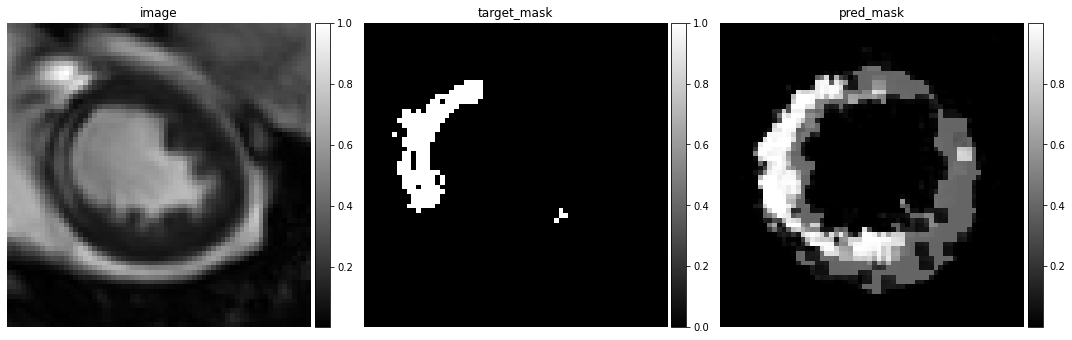

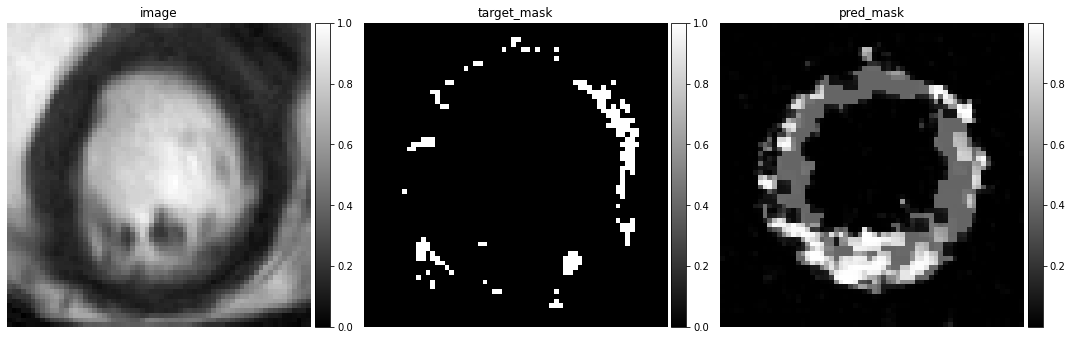

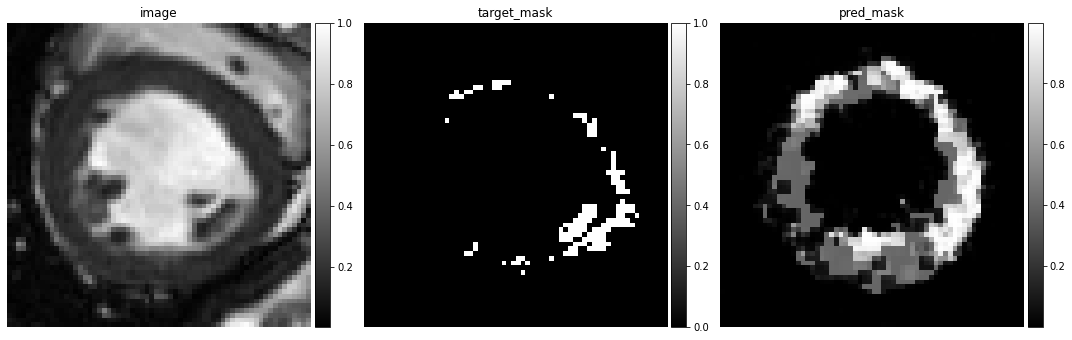

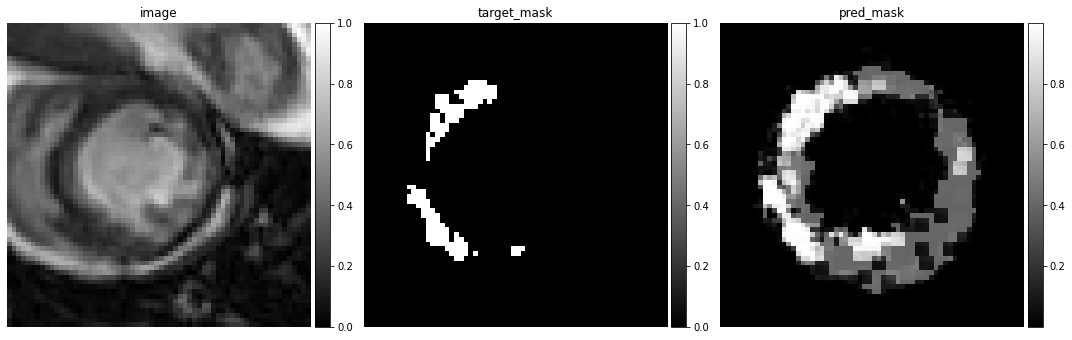

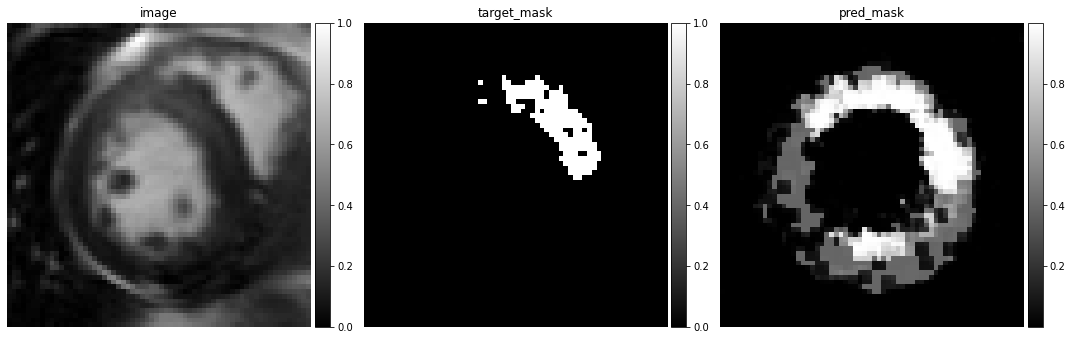

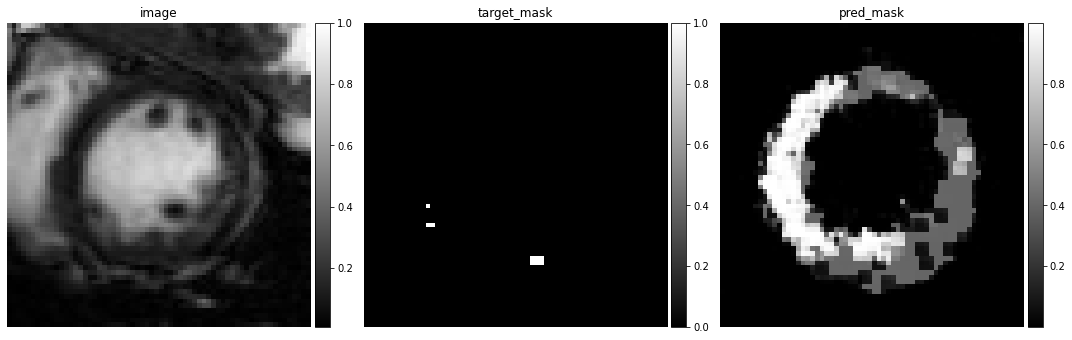

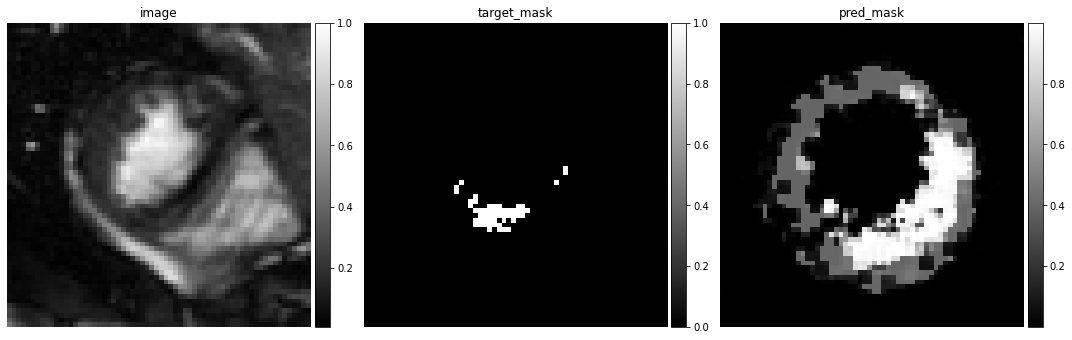

In [19]:
model.eval()
counter = 0
for cine_seri, target_mask in train_dataloader:
    
    # cine_seri.shape: (bs, seq_len, H, W), target_mask.shape: (bs, H, W)
    bs = target_mask.shape[0]

    # predict
    with torch.no_grad():
        pred_mask = model(cine_seri.to('cuda'))

    # visualize
    img = cine_seri[0, 15].detach().cpu().numpy()
    t_m = target_mask[0].detach().cpu().numpy()
    p_m = pred_mask[0].detach().cpu().numpy()
    titles = ['image', 'target_mask', 'pred_mask']
    ne.plot.slices([img, t_m, p_m], titles=titles, cmaps=['gray'], do_colorbars=True, imshow_args=[{'origin':'lower'}]);

    counter += 1
    if counter == 10:
        break
    

## evaluate

In [29]:
def get_binary(src, threshold=0.7):
    one = torch.ones_like(src).to('cuda')
    zero = torch.zeros_like(src).to('cuda')
    out = torch.where(src > threshold, one, zero)
    
    return out

In [30]:
model.eval()

dice_loss_function = losses.Dice().loss
acc_loss_function = losses.Accuracy().loss

dataloader_ = test_dataloader

In [31]:
dice_loss = 0
acc_loss = 0

for cine_seri, target_mask in dataloader_:

    # cine_seri.shape: (bs, seq_len, H, W), target_mask.shape: (bs, H, W)
    bs = cine_seri.shape[0]

    # predict
    with torch.no_grad():
        pred_mask = model(cine_seri.to('cuda'))

    dice_loss += loss_function(target_mask.to('cuda'), pred_mask) * bs
    acc_loss += acc_loss_function(target_mask.to('cuda'), get_binary(pred_mask)) * bs


dice_loss /= len(dataloader_.dataset)
acc_loss /= len(dataloader_.dataset)

print('dice_score=%.4f' % (-dice_loss.detach().cpu().numpy()))
print('accuracy=%.4f' % (-acc_loss.detach().cpu().numpy()))

dice_score=0.2049
accuracy=0.9136
dice_score=0.2049
accuracy=0.9136
